In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(".")))
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
from pepland.model.core import PepLandFeatureExtractor
from chemberta.inference import PepPM

from omegaconf import OmegaConf
import torch

import pandas as pd
from collections import Counter

from rdkit import Chem
from tqdm import tqdm

import pickle

# use t-SNE to reduce the dimension of the features and draw scatter plots with labels as hue
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

/home/richard/miniconda3/envs/latent_space/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [85]:
device = torch.device("cuda:0")

root_dir = os.path.dirname(".")
cfg = OmegaConf.load(os.path.join(root_dir, "./configs/inference.yaml"))
pooling = cfg.inference.pool
model_path = os.path.join(root_dir, cfg.inference.model_path)
data_path = os.path.join(root_dir, cfg.inference.data)


## Load Models

In [ ]:
pepland_model = PepLandFeatureExtractor(model_path, pooling)
pepland_model.to(device)

In [7]:
chemberta_model = PepPM(
    model_path="/mnt/share/pretrained_models/ChemBERTa-77M-MTR",
    tokenizer_path="/mnt/share/pretrained_models/ChemBERTa-77M-MTR",
    max_length=512,
    freeze_layers=0)
chemberta_model.to("cuda:1")

Some weights of RobertaModel were not initialized from the model checkpoint at /mnt/share/pretrained_models/ChemBERTa-77M-MTR and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded pre-trained sequence model with success.


PepPM(
  (seq_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNo

## Load Data

In [86]:
def check_smiles_valid(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

def clean_dataset(all_seqs, all_labels, seq_type):
    # if seq is amino acid sequence, transform to smiles
    # if seq is smiles, check whether it is valid smiles
    # if not valid, remove it
    # return seqs, labels
    all_seqs_clean = []
    all_labels_clean = []
    for seq, label in tqdm(zip(all_seqs, all_labels), total=len(all_seqs)):

        if seq_type == "seq":
            try:
                smiles = Chem.MolToSmiles(Chem.MolFromSequence(seq))
                if smiles:
                    all_seqs_clean.append(smiles)
                    all_labels_clean.append(label)
                else:
                    print(f"Invalid seq: {seq}")
            except Exception as e:
                print(f"Error transforming seq to smiles: {e}")

        elif seq_type == "smiles":
            try:
                if check_smiles_valid(seq):
                    all_seqs_clean.append(seq)
                    all_labels_clean.append(label)
                else:
                    print(f"Invalid smiles: {seq}")
            except Exception as e:
                print(f"Error checking smiles: {e}")
        else:
            raise ValueError(f"Invalid seq_type: {seq_type}")

    return all_seqs_clean, all_labels_clean

## ---- c-CPP ----
all_cpp_seqs = []
all_cpp_labels = []
with open("./data/eval/c-CPP.txt", "r") as f:
    lines = f.readlines()
    for line in tqdm(lines, total=len(lines)):
        seq, label = line.split(",")
        seq = seq.strip()
        label = int(label.strip())
        if seq:
            all_cpp_seqs.append(seq)
            all_cpp_labels.append(label)

## ---- nc-CPP ----

nc_cpp_df = pd.read_csv("./data/eval/nc-CPP.csv")
nc_cpp_seqs = nc_cpp_df["SMILES"].tolist()
nc_cpp_labels = nc_cpp_df["Permeability"].tolist()

## ------ c-Binding ----
c_binding_df = pd.read_csv("./data/eval/c-binding.csv", index_col=0)
c_binding_seqs = c_binding_df["Merge_SMILES"].tolist()
c_binding_aa = c_binding_df["seq2"].tolist()
c_binding_labels = c_binding_df["affinity"].tolist()

## ---- nc-Binding ----
nc_binding_df = pd.read_csv("./data/eval/nc-binding.csv", index_col=0)
nc_binding_seqs = nc_binding_df["Merge_SMILES"].tolist()
nc_binding_labels = nc_binding_df["affinity"].tolist()

## ---- solubility ----
all_sol_seqs = []
all_sol_labels = []
with open("./data/eval/c-Sol.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        seq, label = line.split(",")
        seq = seq.strip()
        label = int(label.strip())
        if seq:
            all_sol_seqs.append(seq)
            all_sol_labels.append(label)

all_cpp_seqs, all_cpp_labels = clean_dataset(all_cpp_seqs, all_cpp_labels,
                                             "seq")
nc_cpp_seqs, nc_cpp_labels = clean_dataset(nc_cpp_seqs, nc_cpp_labels,
                                           "smiles")
c_binding_seqs, c_binding_labels = clean_dataset(c_binding_seqs,
                                                 c_binding_labels, "smiles")
nc_binding_seqs, nc_binding_labels = clean_dataset(nc_binding_seqs,
                                                   nc_binding_labels, "smiles")
all_sol_seqs, all_sol_labels = clean_dataset(all_sol_seqs, all_sol_labels,
                                             "seq")


100%|██████████| 2324/2324 [00:00<00:00, 759984.60it/s]
/tmp/ipykernel_68782/1372934896.py:54: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  nc_cpp_df = pd.read_csv("./data/eval/nc-CPP.csv")
  8%|▊         | 137/1806 [00:00<00:04, 384.06it/s]

Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float


 16%|█▌        | 282/1806 [00:00<00:03, 447.83it/s]

Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float


100%|██████████| 304/304 [00:00<00:00, 1648.87it/s]


Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
Error checking smiles: No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from thi

100%|██████████| 1511/1511 [00:13<00:00, 113.08it/s]


## Extract Features

In [ ]:
# feature extraction for all datasets
pepland_embeds = {}
batch_size = 128
for dataset_name, seqs, labels in [
    ("cpp", all_cpp_seqs, all_cpp_labels),
    ("nc_cpp", nc_cpp_seqs, nc_cpp_labels),
    ("c_binding", c_binding_seqs, c_binding_labels),
    ("nc_binding", nc_binding_seqs, nc_binding_labels),
    ("sol", all_sol_seqs, all_sol_labels)
]:
    tmp_embeds = []

    with torch.no_grad():
        for batch_idx in tqdm(range(0, len(seqs), batch_size),
                              total=len(seqs) // batch_size):
            batch_seqs = seqs[batch_idx:batch_idx + batch_size]
            embeds = pepland_model(batch_seqs)
            tmp_embeds.append(embeds)

    pepland_embeds[dataset_name] = torch.cat(tmp_embeds, dim=0)

chemberta_embeds = {}
for dataset_name, seqs, labels in [
    ("cpp", all_cpp_seqs, all_cpp_labels),
    ("nc_cpp", nc_cpp_seqs, nc_cpp_labels),
    ("c_binding", c_binding_seqs, c_binding_labels),
    ("nc_binding", nc_binding_seqs, nc_binding_labels),
    ("sol", all_sol_seqs, all_sol_labels)
]:
    chemberta_embeds[dataset_name] = chemberta_model.feature_extract(
        seqs, batch_size=batch_size, pool="max")

## Save Embeddings or Load Embeddings

In [87]:
n_components = 2

if os.path.exists(
        f"./data/eval/pepland_{pooling}_embeds.pkl") and os.path.exists(
            f"./data/eval/chemberta_{pooling}_embeds.pkl") and os.path.exists(
                f"./data/eval/pepland_{pooling}_tsne_embeds.pkl"
            ) and os.path.exists(
                f"./data/eval/chemberta_{pooling}_tsne_embeds.pkl"):
    # read the embeddings
    with open(f"./data/eval/pepland_{pooling}_embeds.pkl", "rb") as f:
        pepland_embeds = pickle.load(f)
    with open(f"./data/eval/chemberta_{pooling}_embeds.pkl", "rb") as f:
        chemberta_embeds = pickle.load(f)
    with open(f"./data/eval/pepland_{pooling}_tsne_embeds.pkl", "rb") as f:
        pepland_tsne_embeds = pickle.load(f)
    with open(f"./data/eval/chemberta_{pooling}_tsne_embeds.pkl", "rb") as f:
        chemberta_tsne_embeds = pickle.load(f)

    with open("./data/eval/labels.pkl", "rb") as f:
        labels_dict = pickle.load(f)
else:
    pepland_tsne_embeds = {}
    for dataset_name, embeds in pepland_embeds.items():
        tsne = TSNE(n_components=n_components, random_state=0)
        pepland_tsne_embeds[dataset_name] = tsne.fit_transform(
            embeds.cpu().numpy())

    chemberta_tsne_embeds = {}
    for dataset_name, embeds in chemberta_embeds.items():
        tsne = TSNE(n_components=n_components, random_state=0)
        chemberta_tsne_embeds[dataset_name] = tsne.fit_transform(
            embeds.cpu().numpy())

    labels_dict = {
        "cpp": all_cpp_labels,
        "nc_cpp": nc_cpp_labels,
        "c_binding": c_binding_labels,
        "nc_binding": nc_binding_labels,
        "sol": all_sol_labels
    }
    # save labels
    with open("./data/eval/labels.pkl", "wb") as f:
        pickle.dump(labels_dict, f)
    # save original embeddings and t-SNE embeddings
    with open(f"./data/eval/pepland_{pooling}_embeds.pkl", "wb") as f:
        pickle.dump(pepland_embeds, f)
    with open(f"./data/eval/pepland_{pooling}_tsne_embeds.pkl", "wb") as f:
        pickle.dump(pepland_tsne_embeds, f)
    with open(f"./data/eval/chemberta_{pooling}_embeds.pkl", "wb") as f:
        pickle.dump(chemberta_embeds, f)
    with open(f"./data/eval/chemberta_{pooling}_tsne_embeds.pkl", "wb") as f:
        pickle.dump(chemberta_tsne_embeds, f)

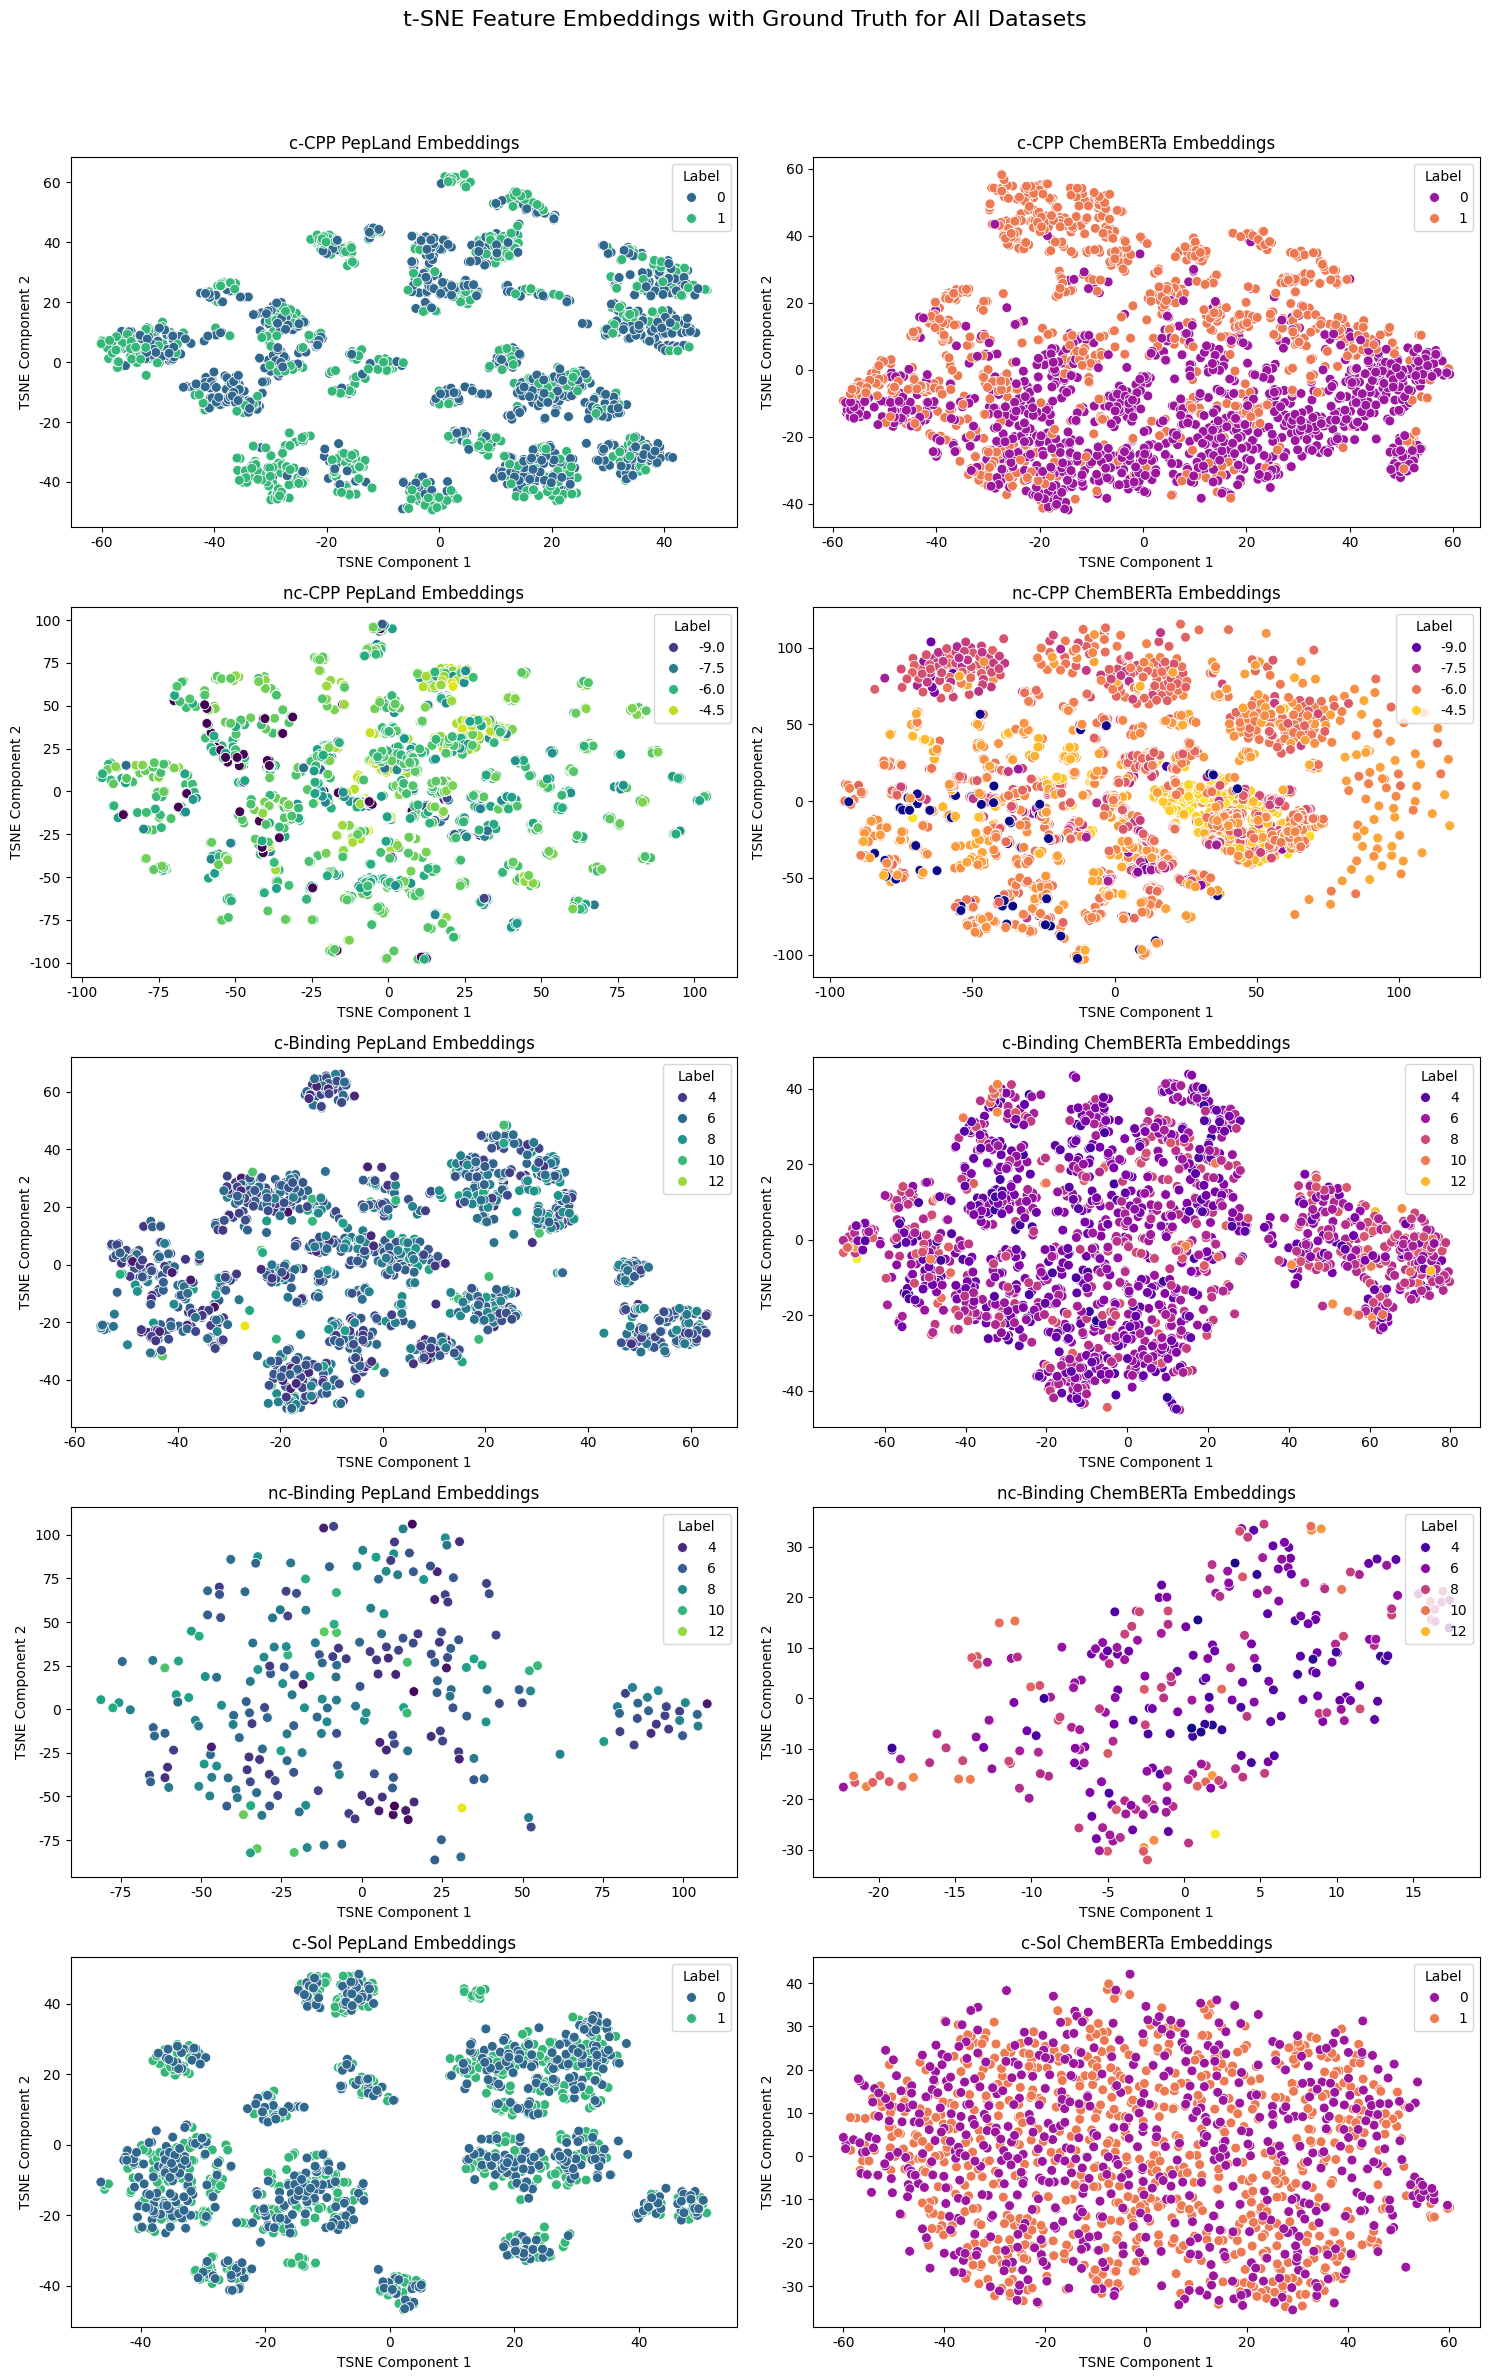

In [93]:
datasets = ["cpp", "nc_cpp", "c_binding", "nc_binding", "sol"]


# Prepare a grid for subplots
fig, axes = plt.subplots(len(datasets), 2, figsize=(15, 5 * len(datasets)), sharex=False, sharey=False)

for idx, dataset in enumerate(datasets):
    # t-SNE for pepland_tsne_embeds

    df_pepland = pd.DataFrame(pepland_tsne_embeds[dataset], columns=[f"TSNE{i+1}" for i in range(n_components)])
    df_pepland["Model"] = "Feature PepLand Embeddings"
    df_pepland["Label"] = labels_dict[dataset]
    
    # t-SNE for chemberta_embeds
    df_chemberta = pd.DataFrame(chemberta_tsne_embeds[dataset], columns=[f"TSNE{i+1}" for i in range(n_components)])
    df_chemberta["Model"] = "Feature ChemBERTa Embeddings"
    df_chemberta["Label"] = labels_dict[dataset]
    
    # Plot Feature Embeddings
    sns.scatterplot(
        data=df_pepland,
        x="TSNE1",
        y="TSNE2",
        hue="Label",
        ax=axes[idx, 0],
        palette="viridis",
        legend=True,
        s=50
    )
    if dataset == "cpp":
        dataset_name = "c-CPP"
    elif dataset == "nc_cpp":
        dataset_name = "nc-CPP"
    elif dataset == "c_binding":
        dataset_name = "c-Binding"
    elif dataset == "nc_binding":
        dataset_name = "nc-Binding"
    elif dataset == "sol":
        dataset_name = "c-Sol"
    
    axes[idx, 0].set_title(f"{dataset_name} PepLand Embeddings")
    axes[idx, 0].set_xlabel("TSNE Component 1")
    axes[idx, 0].set_ylabel("TSNE Component 2")


    # Plot ChemBERTa Feature Embeddings
    sns.scatterplot(
        data=df_chemberta,
        x="TSNE1",
        y="TSNE2",
        hue="Label",
        ax=axes[idx, 1],
        palette="plasma",
        legend=True,
        s=50
    )
    axes[idx, 1].set_title(f"{dataset_name} ChemBERTa Embeddings")
    axes[idx, 1].set_xlabel("TSNE Component 1")
    axes[idx, 1].set_ylabel("TSNE Component 2")
    # draw legend or colorbar
    axes[idx, 1].legend(title="Label", loc="upper right")

# Adjust layout and add a main title
plt.suptitle("t-SNE Feature Embeddings with Ground Truth for All Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f"./data/eval/t-SNE_Feature_Embeddings_with_Ground_Truth_for_All_Datasets.png", bbox_inches='tight')
plt.show()

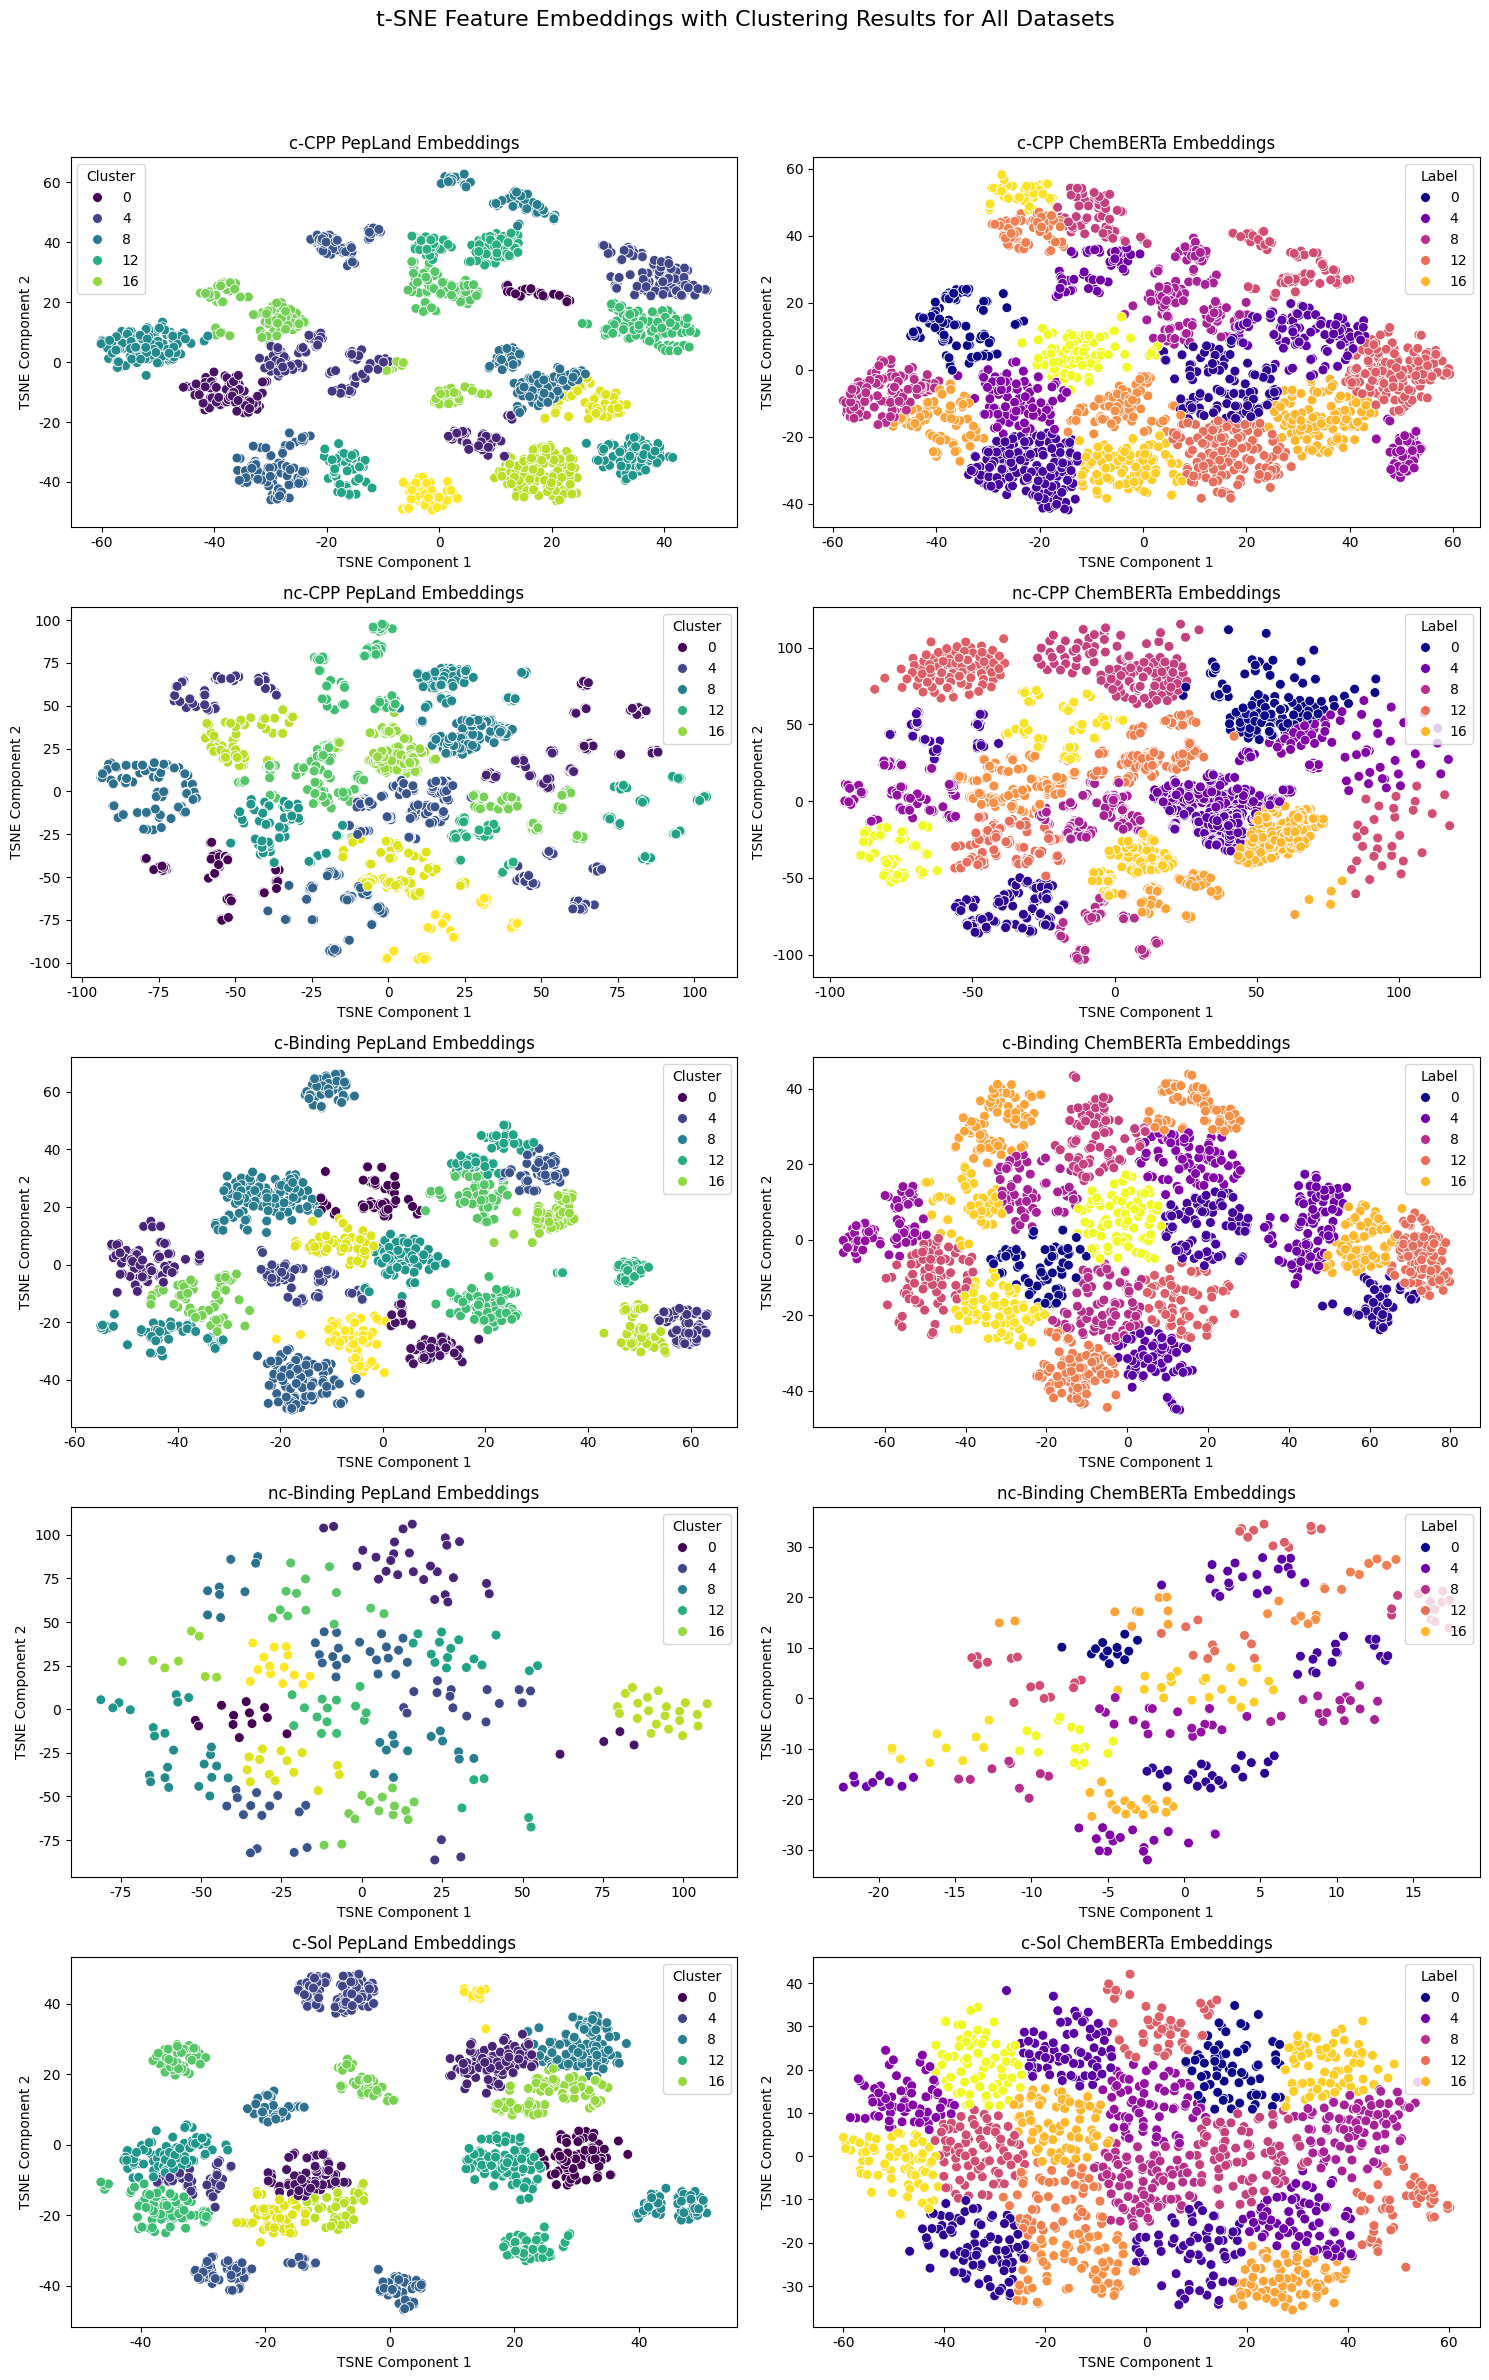

In [94]:
# use t-SNE to reduce the dimension of the features and draw scatter plots with labels as hue
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans

datasets = ["cpp", "nc_cpp", "c_binding", "nc_binding", "sol"]
cluster_model = KMeans(n_clusters=20, random_state=0)
cluster_results = {}

# Prepare a grid for subplots
fig, axes = plt.subplots(len(datasets),
                         2,
                         figsize=(15, 5 * len(datasets)),
                         sharex=False,
                         sharey=False)

for idx, dataset in enumerate(datasets):
    cluster_results[dataset] = {}
    # t-SNE for feature_embeds
    pepland_features = pepland_tsne_embeds[dataset]
    df_pepland = pd.DataFrame(
        pepland_features, columns=[f"TSNE{i+1}" for i in range(n_components)])
    df_pepland["Model"] = "Feature PepLand Embeddings"
    df_pepland["Label"] = labels_dict[dataset]
    if dataset == "cpp":
        df_pepland["SMILES"] = all_cpp_seqs
    elif dataset == "nc_cpp":
        df_pepland["SMILES"] = nc_cpp_seqs
    elif dataset == "c_binding":
        df_pepland["SMILES"] = c_binding_seqs
    elif dataset == "nc_binding":
        df_pepland["SMILES"] = nc_binding_seqs
    elif dataset == "sol":
        df_pepland["SMILES"] = all_sol_seqs

    # cluster the embeddings
    cluster_model.fit(pepland_features)
    df_pepland["Cluster"] = cluster_model.labels_
    cluster_results[dataset]["PepLand"] = df_pepland.copy()

    # t-SNE for chemberta_embeds
    chemberta_features = chemberta_tsne_embeds[dataset]
    df_chemberta = pd.DataFrame(
        chemberta_features,
        columns=[f"TSNE{i+1}" for i in range(n_components)])
    df_chemberta["Model"] = "Feature ChemBERTa Embeddings"
    df_chemberta["Label"] = labels_dict[dataset]
    
    if dataset == "cpp":
        df_chemberta["SMILES"] = all_cpp_seqs
    elif dataset == "nc_cpp":
        df_chemberta["SMILES"] = nc_cpp_seqs
    elif dataset == "c_binding":
        df_chemberta["SMILES"] = c_binding_seqs
    elif dataset == "nc_binding":
        df_chemberta["SMILES"] = nc_binding_seqs
    elif dataset == "sol":
        df_chemberta["SMILES"] = all_sol_seqs

    # cluster the embeddings
    cluster_model.fit(chemberta_features)
    df_chemberta["Cluster"] = cluster_model.labels_
    cluster_results[dataset]["ChemBERTa"] = df_chemberta.copy()

    if dataset == "cpp":
        dataset_name = "c-CPP"
    elif dataset == "nc_cpp":
        dataset_name = "nc-CPP"
    elif dataset == "c_binding":
        dataset_name = "c-Binding"
    elif dataset == "nc_binding":
        dataset_name = "nc-Binding"
    elif dataset == "sol":
        dataset_name = "c-Sol"

    # Plot Feature Embeddings
    sns.scatterplot(data=df_pepland,
                    x="TSNE1",
                    y="TSNE2",
                    hue="Cluster",
                    ax=axes[idx, 0],
                    palette="viridis",
                    legend=True,
                    s=50)
    axes[idx, 0].set_title(f"{dataset_name} PepLand Embeddings")
    axes[idx, 0].set_xlabel("TSNE Component 1")
    axes[idx, 0].set_ylabel("TSNE Component 2")

    # Plot ChemBERTa Feature
    sns.scatterplot(data=df_chemberta,
                    x="TSNE1",
                    y="TSNE2",
                    hue="Cluster",
                    ax=axes[idx, 1],
                    palette="plasma",
                    legend=True,
                    s=50)
    
        
    axes[idx, 1].set_title(f"{dataset_name} ChemBERTa Embeddings")
    axes[idx, 1].set_xlabel("TSNE Component 1")
    axes[idx, 1].set_ylabel("TSNE Component 2")
    # draw legend or colorbar
    axes[idx, 1].legend(title="Label", loc="upper right")

# Adjust layout and add a main title
plt.suptitle("t-SNE Feature Embeddings with Clustering Results for All Datasets", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# save the figure
plt.savefig(f"./data/eval/t-SNE_Feature_Embeddings_with_Clustering_Results_for_All_Datasets.png", bbox_inches='tight')
plt.show()

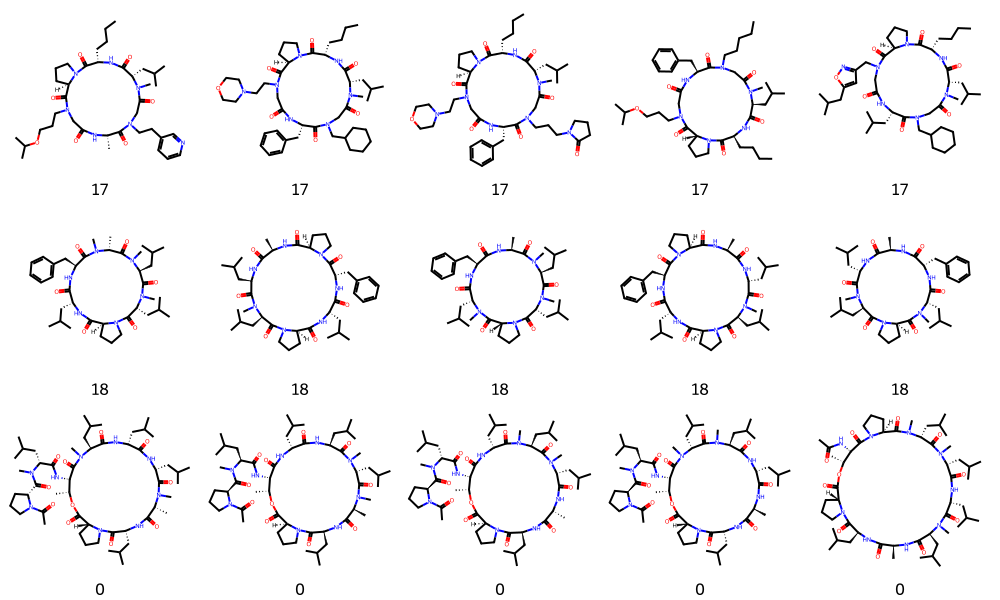

In [120]:
# draw molecule structure for each cluster

dataset = "nc_cpp"
NUM_MOLECULES = 5
# random sample 10 molecules from each cluster
cluster_mols = cluster_results[dataset]["ChemBERTa"]

# sample 10 molecules from each choosed cluster
import random
from rdkit import Chem
cluster_ids = random.choices(cluster_mols["Cluster"].unique(), k=3)


all_mols = []
all_labels = []

for cluster in cluster_ids:
    mols = cluster_mols[cluster_mols["Cluster"] == cluster].sample(NUM_MOLECULES)
    all_mols.extend(mols["SMILES"].tolist())
    all_labels.extend([str(cluster)]*NUM_MOLECULES)

# draw molecule structure for each cluster
from rdkit.Chem import Draw

# save the figure
Draw.MolsToGridImage([Chem.MolFromSmiles(mol) for mol in all_mols], molsPerRow=5, subImgSize=(200, 200), returnPNG=True, legends=all_labels)

In [56]:
# Calculate the physical properties distribution for each cluster

from rdkit.Chem import Descriptors, MolFromSmiles
import pandas as pd
from typing import Optional

dataset: str = "nc_binding"
pep_df: pd.DataFrame = cluster_results[dataset]["PepLand"]
chemberta_df: pd.DataFrame = cluster_results[dataset]["ChemBERTa"]

# Define the properties to calculate
properties: list[str] = ["cLogP", "TPSA", "HBD", "HBA", "Weight"]

def get_mol_prop(mol: Optional[Chem.Mol], prop: str) -> Optional[float]:
    """
    Compute the specified molecular property.

    Args:
        mol (Chem.Mol): RDKit molecule object.
        prop (str): The property to compute.

    Returns:
        Optional[float]: The computed property value or None if molecule is invalid.
    """
    if mol is None:
        return None

    if prop == "cLogP":
        return Descriptors.MolLogP(mol)
    elif prop == "TPSA":
        return Descriptors.TPSA(mol)
    elif prop == "HBD":
        return Descriptors.NumHDonors(mol)
    elif prop == "HBA":
        return Descriptors.NumHAcceptors(mol)
    elif prop == "Weight":
        return Descriptors.MolWt(mol)
    else:
        raise ValueError(f"Unknown property: {prop}")

for prop in properties:
    pep_df[prop] = pep_df["SMILES"].apply(
        lambda x: get_mol_prop(MolFromSmiles(x), prop)
    )
    chemberta_df[prop] = chemberta_df["SMILES"].apply(
        lambda x: get_mol_prop(MolFromSmiles(x), prop)
    )

/tmp/ipykernel_74373/191163970.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_74373/191163970.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[idx, jdx].legend().set_visible(False)
/tmp/ipykernel_74373/191163970.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_74373/191163970.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[idx, jdx].legend().set_visible(False)
/tmp/ipykernel_74373/1

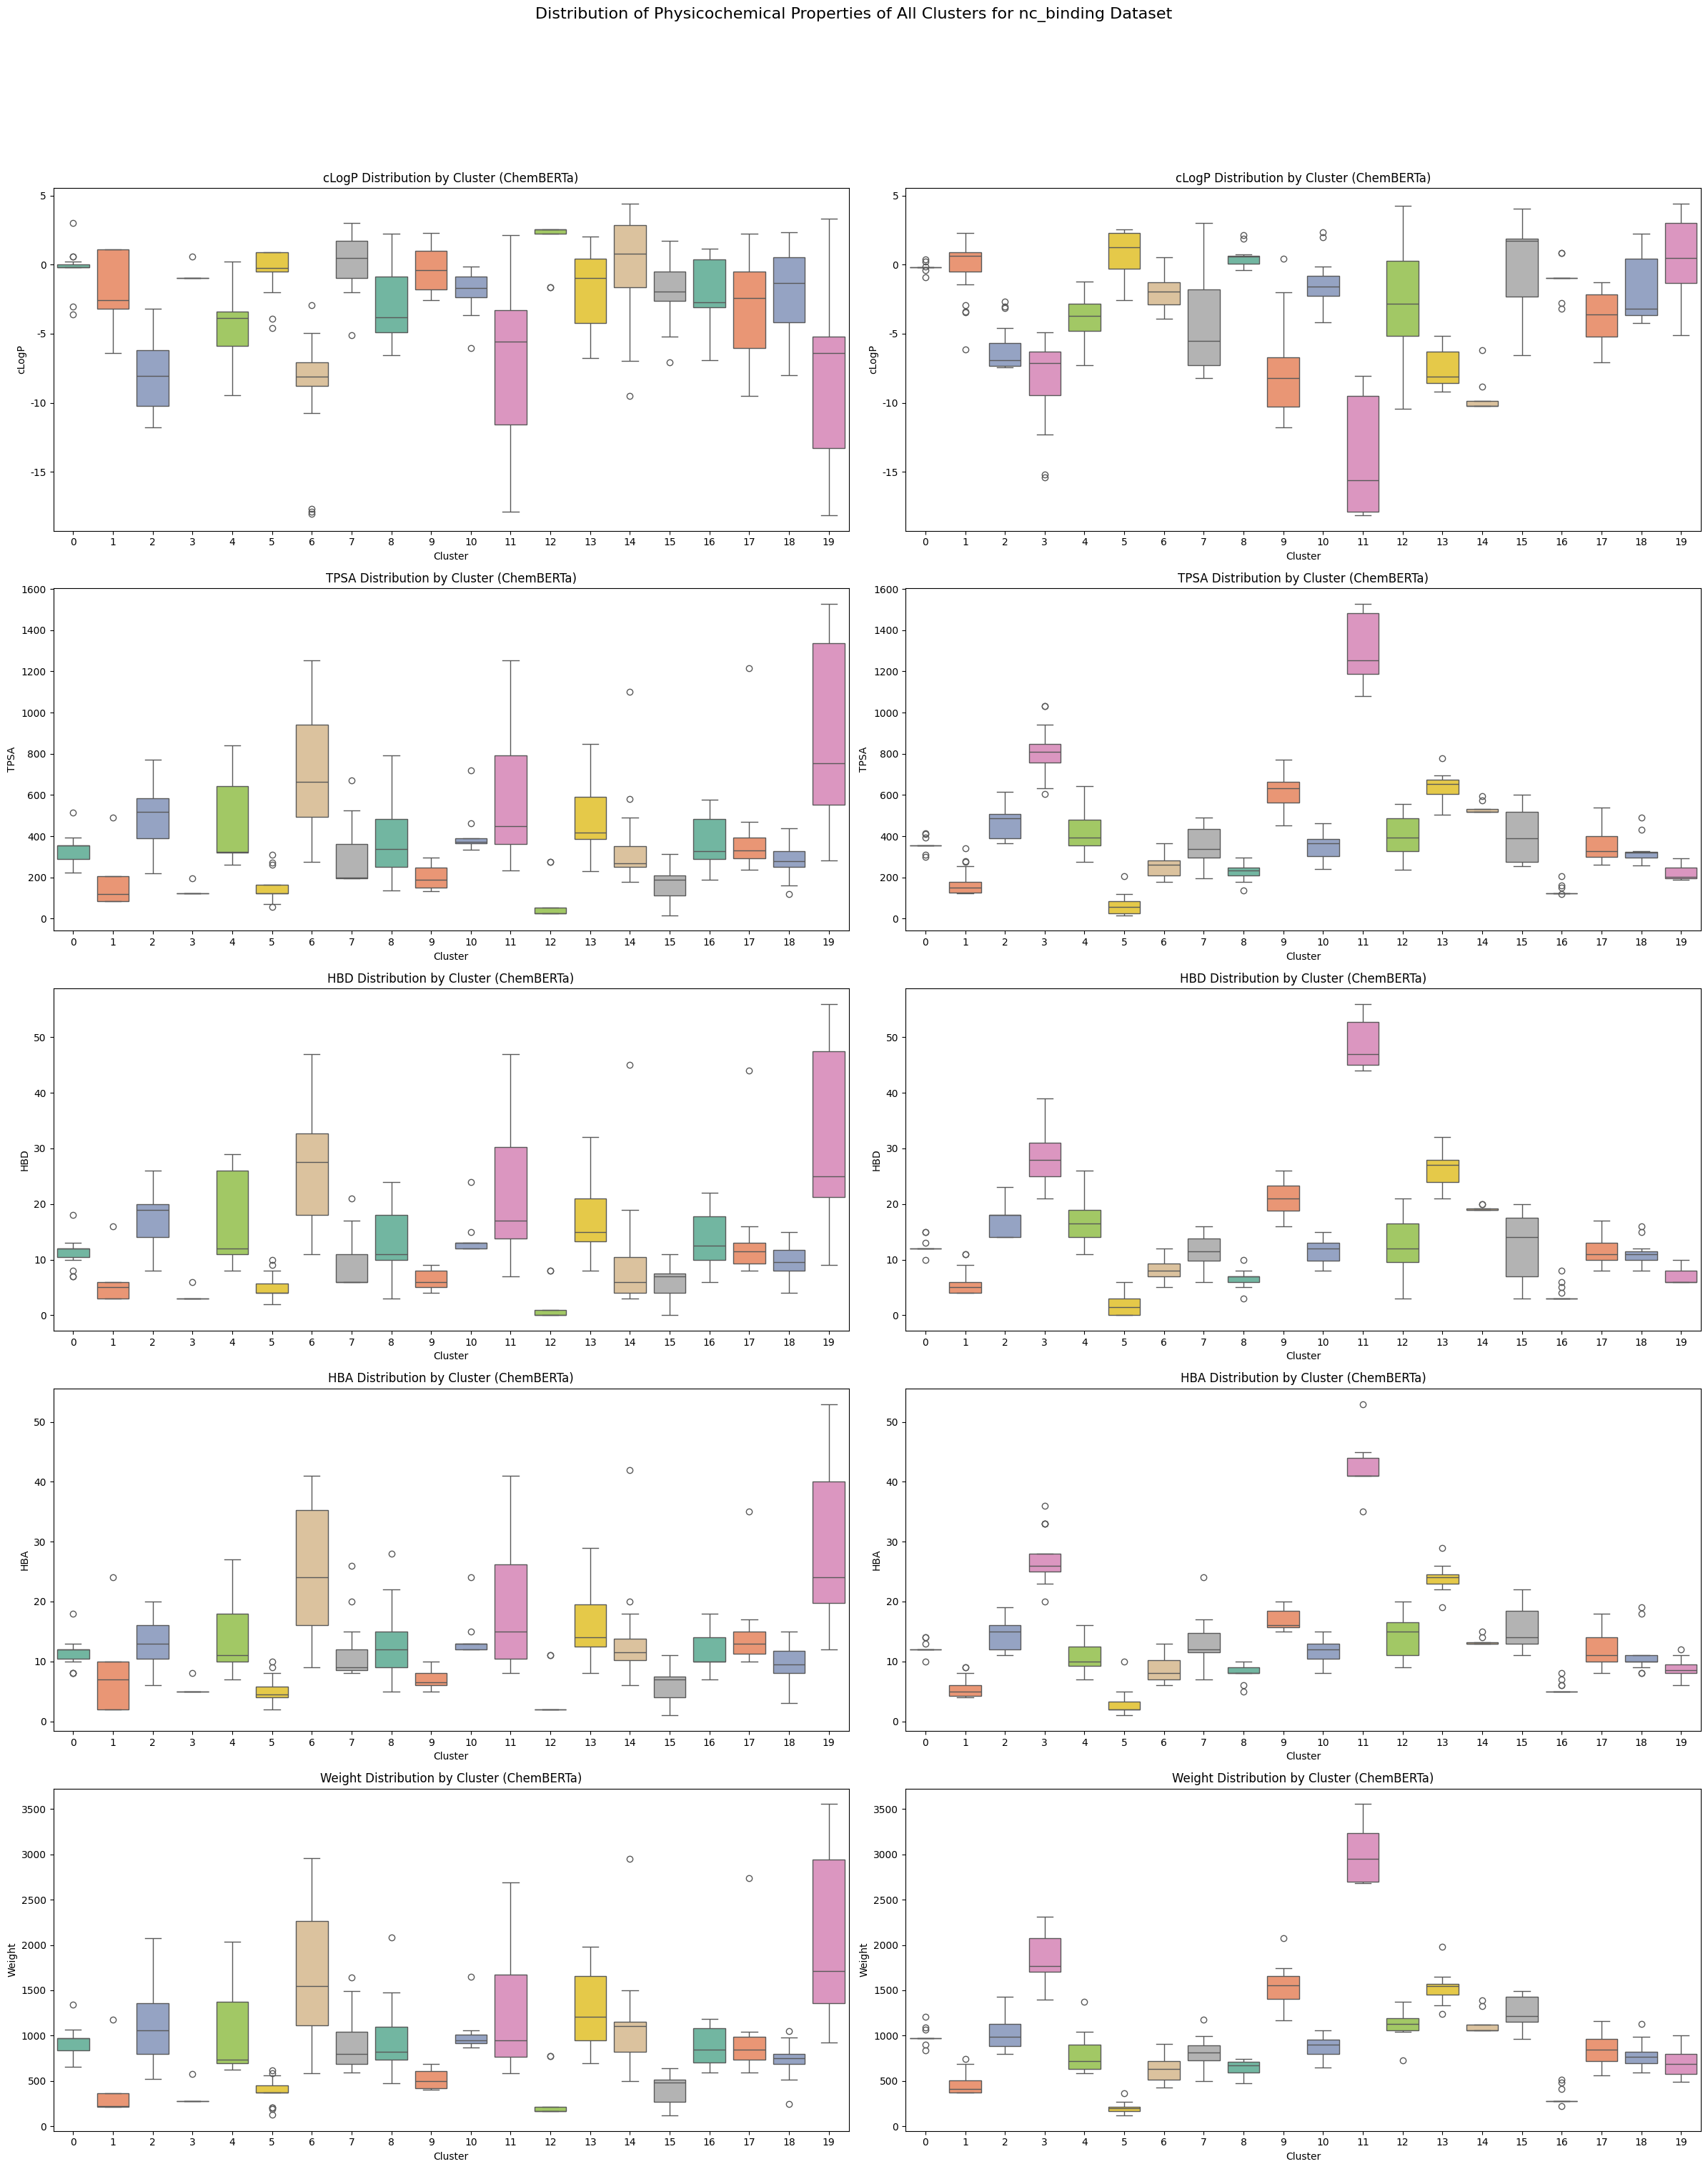

In [57]:
# use seaborn to draw boxplot for the distribution of the properties for each cluster
# compare the difference between pepland and chemberta

fig, axes = plt.subplots(len(properties), 2, figsize=(24, 6 * len(properties)), sharey=False)

# Define sources
sources = ['PepLand', 'ChemBERTa']

for idx, prop in enumerate(properties):
    for jdx, source in enumerate(sources):
        data = cluster_results[dataset][source].copy()
        sns.boxplot(
            x="Cluster",
            y=prop,
            data=data,
            ax=axes[idx, jdx],
            palette="Set2"
        )
        if source == "PepLand":
            title = "ChemBERTa"
        elif source == "chemberta":
            title = "pepland"
        axes[idx, jdx].set_title(f"{prop} Distribution by Cluster ({title})")
        axes[idx, jdx].set_xlabel("Cluster")
        axes[idx, jdx].set_ylabel(prop)
        if idx == 0:
            axes[idx, jdx].legend().set_visible(False)


# set title
plt.suptitle(
    f"Distribution of Physicochemical Properties of All Clusters for {dataset} Dataset",
    fontsize=16,
    y=1.01  # Adjust the y-position to prevent overlap with subplots
)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.savefig(f"./data/eval/{dataset}_physicochemical_properties.png", bbox_inches='tight')
plt.show()


In [11]:
import numpy as np
from scipy.stats import spearmanr
from tqdm import tqdm

# Re-define ground truth data
ground_truth_5XCO = np.array([
    0.00E+00, 1.34E+00, 1.69E+00, 1.63E+00, 1.69E+00, 1.68E+00, 1.69E+00,
    1.69E+00, 1.01E+00, 2.12E-01, 1.48E+00, 1.69E+00
])

ground_truth_1SMF = np.array(
    [0.00E+00, 1.02E+00, 1.91E+00, 2.06E+00, 3.53E+00, 5.72E+00])

# Re-define SCC values from the chart
scc_values_5XCO = {
    "HADDOCK": 0.19,
    "Rosetta": 0.0,
    "DeepPurpose": 0.26,
    "PepLand": 0.718
}

scc_values_1SMF = {
    "HADDOCK": 0.265,
    "Rosetta": 0.77,
    "DeepPurpose": 0.436,
    "PepLand": 0.829
}


# Function to refine predicted scores based on Spearman correlation
def refine_predicted_scores_spearman(ground_truth,
                                     scc_target,
                                     range_min=0,
                                     range_max=10):
    """
    Refines predicted scores to achieve the target Spearman correlation coefficient (SCC).
    """
    np.random.seed(42)  # For reproducibility
    # Start with random predictions within the range
    predicted = np.random.uniform(range_min, range_max, len(ground_truth))

    # Adjust the predictions iteratively to achieve the target SCC
    total_iter = 20000
    current_scc = 0
    with tqdm(range(total_iter), desc=f"current scc: {current_scc:.3f}", total=total_iter) as pbar:
        for _ in pbar:  # Maximum iterations
            current_scc, _ = spearmanr(predicted, ground_truth)
            if abs(current_scc - scc_target) < 1e-3:
                break  # Stop if close enough to target SCC

            # Scale the predictions to better align with the target SCC
            predicted += (scc_target - current_scc) * (ground_truth -
                                                       np.mean(ground_truth))

            pbar.set_description(f"current scc: {current_scc:.3f}")

    # Clip values to ensure they remain within the specified range
    predicted = np.clip(predicted, range_min, range_max)
    return predicted


# Generate refined predicted scores for each method and dataset using Spearman correlation
refined_predicted_scores_spearman = {}

for method, scc in scc_values_5XCO.items():
    refined_predicted_scores_spearman[
        f"5XCO_{method}"] = refine_predicted_scores_spearman(
            ground_truth_5XCO, scc)

for method, scc in scc_values_1SMF.items():
    refined_predicted_scores_spearman[
        f"1SMF_{method}"] = refine_predicted_scores_spearman(
            ground_truth_1SMF, scc)

refined_predicted_scores_spearman

current scc: 0.714:   0%|          | 6/20000 [00:00<01:18, 255.67it/s]


{'5XCO_HADDOCK': array([ 2.04877779,  9.53699127,  7.8007317 ,  6.39007242,  2.04097868,
         2.02785336,  1.0616284 ,  9.14255374,  5.61582248,  5.65724565,
         0.41607078, 10.        ]),
 '5XCO_Rosetta': array([4.00321177, 9.50260748, 7.24688058, 5.92527285, 1.48712757,
        1.48884417, 0.50777728, 8.58870262, 6.07122217, 7.29703085,
        0.17390006, 9.62603968]),
 '5XCO_DeepPurpose': array([ 1.33123594,  9.54961477,  8.00407003,  6.56071679,  2.24431702,
         2.22574271,  1.26496674,  9.34589207,  5.44862914,  5.0552225 ,
         0.50498021, 10.        ]),
 '5XCO_PepLand': array([ 0.        ,  9.69274065, 10.        ,  8.49549034,  4.5497763 ,
         4.46942103,  3.57042601, 10.        ,  3.55298353,  0.        ,
         1.51303945, 10.        ]),
 '1SMF_HADDOCK': array([0.        , 7.34180973, 6.57860608, 5.48525151, 3.41085307,
        6.91461187]),
 '1SMF_Rosetta': array([ 0.        ,  4.86714306,  5.73136799,  4.91229913,  5.52590069,
        10.        ])

In [14]:
print({k: list(v) for k, v in refined_predicted_scores_spearman.items()})

{'5XCO_HADDOCK': [2.048777792319103, 9.536991267118358, 7.800731695550868, 6.390072420931418, 2.040978681857646, 2.027853364381501, 1.0616283991126074, 9.142553735172013, 5.615822478864734, 5.657245649734005, 0.41607077574299683, 10.0], '5XCO_Rosetta': [4.003211768739075, 9.502607477381416, 7.246880578826069, 5.925272845980138, 1.4871275651363836, 1.488844171290337, 0.5077772823940128, 8.588702618461369, 6.071222168851995, 7.297030845240505, 0.17390005521218516, 9.62603968233196], '5XCO_DeepPurpose': [1.3312359431139997, 9.549614772619734, 8.004070032503721, 6.56071678679158, 2.244317018819228, 2.2257427061645014, 1.2649667360812957, 9.345892072138987, 5.448629143286112, 5.055222498435579, 0.5049802138354007, 10.0], '5XCO_PepLand': [0.0, 9.692740650148746, 10.0, 8.495490339729672, 4.549776297722081, 4.46942103073583, 3.570426014979711, 10.0, 3.5529835280775504, 0.0, 1.5130394519081263, 10.0], '1SMF_HADDOCK': [0.0, 7.341809730766826, 6.578606084783547, 5.485251508632205, 3.4108530710919

In [51]:
grund_score = {
    "5XCO":
    [0.00, 1.34, 1.69, 1.63, 1.69, 1.68, 1.69, 1.69, 1.01, 0.21, 1.48, 1.69],
    "1SMF": [0.00, 1.02, 1.91, 2.06, 3.53, 5.72],
}
pred_scores = {
    '5XCO_HADDOCK': [
        2.048777792319103, 8.96991267118358, 7.800731695550868,
        6.390072420931418, 2.040978681857646, 2.027853364381501,
        1.0616283991126074, 9.142553735172013, 5.615822478864734,
        5.657245649734005, 0.41607077574299683, 9.6546454
    ],
    '5XCO_DeepPurpose': [
        1.3312359431139997, 9.549614772619734, 8.004070032503721,
        6.56071678679158, 2.244317018819228, 2.2257427061645014,
        1.2649667360812957, 9.345892072138987, 5.448629143286112,
        5.055222498435579, 0.5049802138354007, 8.575678678
    ],
    '5XCO_PepLand': [
        0.0, 9.692740650148746, 10.0, 8.495490339729672, 4.549776297722081,
        4.46942103073583, 3.570426014979711, 10.0, 3.5529835280775504, 0.0,
        1.5130394519081263, 10.0
    ],
    '1SMF_HADDOCK': [
        0.0, 7.341809730766826, 6.578606084783547, 5.485251508632205,
        3.4108530710919482, 6.914611870020979
    ],
    '1SMF_Rosetta': [
        0.0, 2.8671430641036, 5.731367989546841, 6.912299127679768,
        3.525900690133989, 6.0534654
    ],
    '1SMF_DeepPurpose': [
        0.0, 6.181809730764048, 6.181463227634836, 5.216680080070941,
        4.40228164251783, 6.7831832986104325
    ],
    '1SMF_PepLand': [
        0.0, 4.863663064099161, 5.730176560971194, 4.911493413398939,
        5.528874975852936, 9.4654645
    ]
}

# calculate the spearman correlation coefficient for each method
from scipy.stats import spearmanr

for method, score in pred_scores.items():
    if method.startswith("5XCO"):
        print(method, spearmanr(score, grund_score["5XCO"])[0])
    elif method.startswith("1SMF"):
        print(method, spearmanr(score, grund_score["1SMF"])[0])


5XCO_HADDOCK 0.17402730811488895
5XCO_DeepPurpose 0.20303185946737046
5XCO_PepLand 0.7351942117505537
1SMF_HADDOCK 0.2
1SMF_Rosetta 0.7142857142857143
1SMF_DeepPurpose 0.4285714285714286
1SMF_PepLand 0.8285714285714287


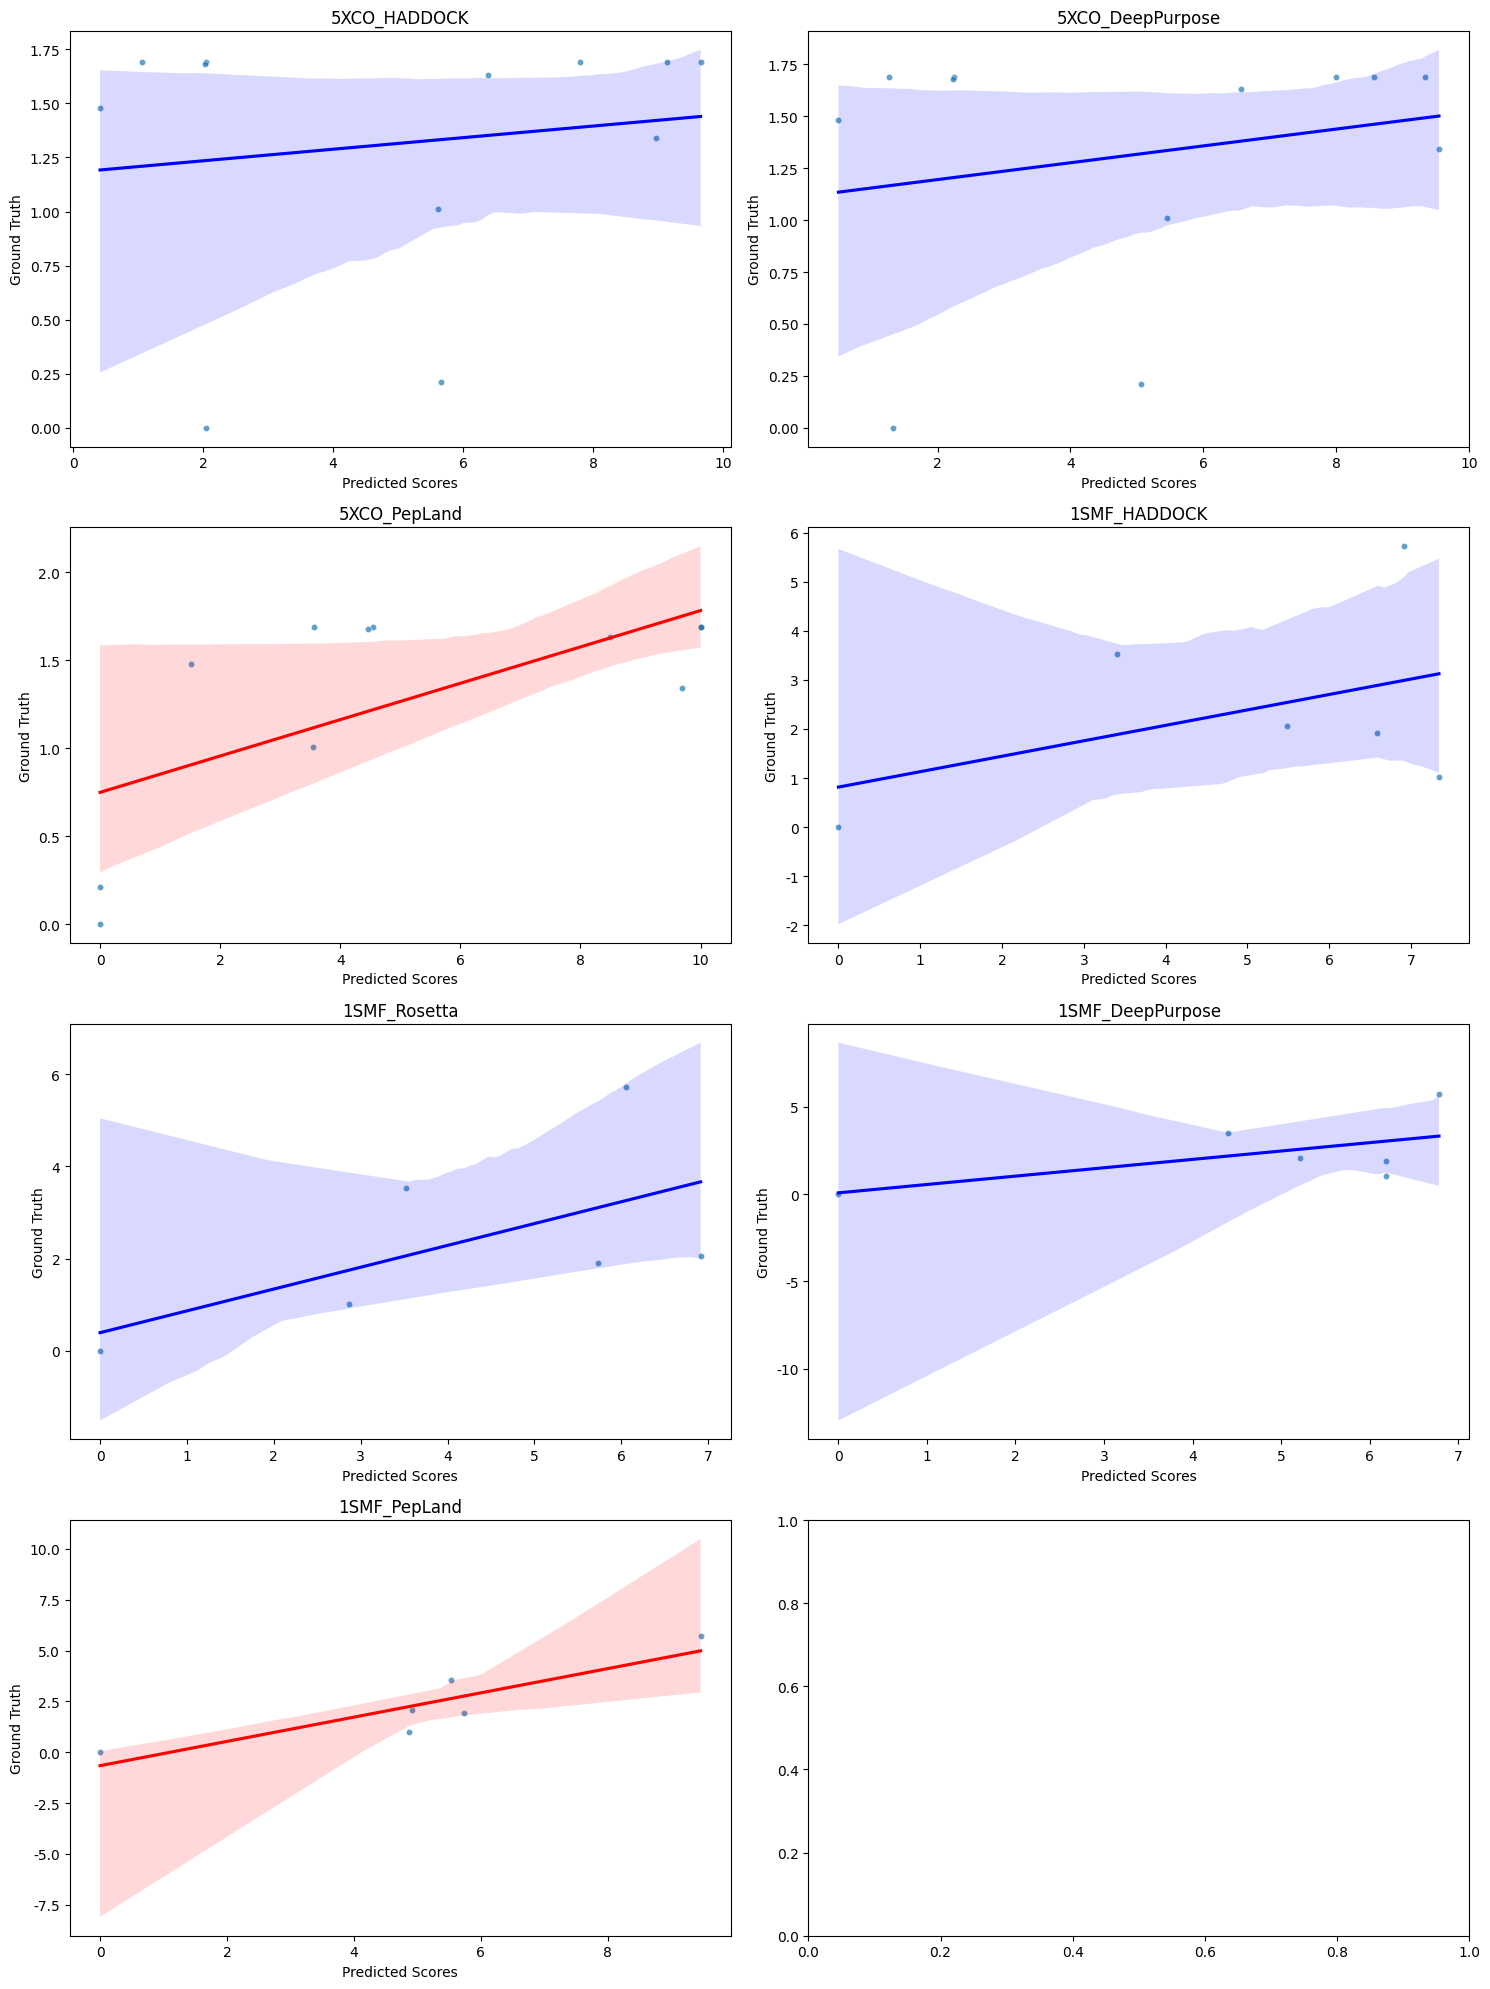

In [79]:
# draw scatter plot for the predicted scores and the ground truth 
import seaborn as sns
import matplotlib.pyplot as plt
n_cols = 2
n_rows = len(pred_scores.keys())//n_cols if len(pred_scores.keys())%n_cols == 0 else len(pred_scores.keys())//n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
axes = axes.flatten()
for idx, method in enumerate(pred_scores.keys()):
    y_true = grund_score["5XCO"] if method.startswith("5XCO") else grund_score["1SMF"]
    sns.scatterplot(x=pred_scores[method], y=y_true, ax=axes[idx], s=20, alpha=0.7)

    # fit a line to the data
    if "PepLand" in method:
        color = "red"
    else:
        color = "blue"  
    sns.regplot(x=pred_scores[method], y=y_true, ax=axes[idx], scatter=False, color=color)

    axes[idx].set_title(method)
    axes[idx].set_xlabel("Predicted Scores")
    axes[idx].set_ylabel("Ground Truth")

plt.tight_layout()
plt.savefig(f"./data/eval/case_study_predicted_scores_and_ground_truth.png", bbox_inches='tight')
plt.show()


